In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 20

# Paths
base_dir = 'pneumonia'  # Update this with the path to your dataset
pneumonia_dir = os.path.join(base_dir, 'Pneumonia')
normal_dir = os.path.join(base_dir, 'Normal')

def load_images_and_labels():
    images = []
    labels = []
    for label, class_dir in enumerate([pneumonia_dir, normal_dir]):
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(file_path)
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels()


In [2]:
# Normalize images
images = images.astype('float32') / 255.0
labels = to_categorical(labels, num_classes=2)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [17]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
cnn_model = Model(inputs=base_model.input, outputs=x)

# Extract features
train_features = cnn_model.predict(X_train)
test_features = cnn_model.predict(X_test)

# Reshape features to be used with LSTM
def create_sequences(features, sequence_length=1):
    sequences = []
    for i in range(0, len(features) - sequence_length + 1):
        sequences.append(features[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 2  # Modify this if you have more complex sequence data
X_train_seq = create_sequences(train_features, sequence_length)
X_test_seq = create_sequences(test_features, sequence_length)


4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [18]:
lstm_input = Input(shape=(sequence_length, train_features.shape[1]))
x = LSTM(256, return_sequences=True)(lstm_input)
x = LSTM(64)(x)
x = Dense(2, activation='softmax')(x)
lstm_model = Model(inputs=lstm_input, outputs=x)

lstm_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = lstm_model.fit(
    X_train_seq, y_train[sequence_length-1:],
    epochs=100,
    batch_size=batch_size,
    validation_split=0.2,
    # callbacks=[early_stopping]
)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.5231 - loss: 0.6925 - val_accuracy: 0.3913 - val_loss: 0.7193
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6033 - loss: 0.6691 - val_accuracy: 0.6087 - val_loss: 0.6512
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5231 - loss: 0.6602 - val_accuracy: 0.7826 - val_loss: 0.6482
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6946 - loss: 0.6332 - val_accuracy: 0.3913 - val_loss: 0.6895
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6456 - loss: 0.6213 - val_accuracy: 0.7826 - val_loss: 0.6027
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8327 - loss: 0.5585 - val_accuracy: 0.7391 - val_loss: 0.5536
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8153 - loss: 0.5094 - val_accuracy: 0.7391 - val_loss: 0.5419
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8303 - loss: 0.4407 - val_accuracy: 0.6957 - val_loss

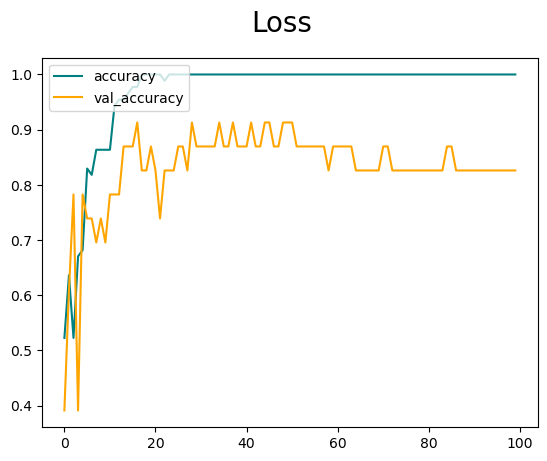

''

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

'''
Optimal Point: The optimal point is where the validation accuracy reaches its highest value before it begins to drop. This peak represents the best generalization capability of the model.
Overfitting Point: Once validation accuracy starts to decrease after this peak, it suggests that overfitting is occurring. The model is memorizing the training data rather than learning patterns that generalize well to validation data.
'''